## Import modules

In [12]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
import segmentation_models as sm

from train import dataset, aug, viz

## Init model

In [2]:
BACKBONE = 'resnet50'
BATCH_SIZE = 16
CLASSES = [
    'Road-non-flooded',
    'Grass'
]
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

In [3]:
# define network parameters
n_classes = len(CLASSES) + 1
activation = 'softmax'

#create model
model = sm.PSPNet(BACKBONE, classes=n_classes, activation=activation)

2023-01-31 15:38:22.312280: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 15:38:22.312881: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/flex/.local/lib/python3.8/site-packages/cv2/../../lib64:/usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/galactic/opt/yaml_cpp_vendor/lib:/opt/ros/galactic/opt/rviz_ogre_vendor/lib:/opt/ros/galactic/lib/x86_64-linux-gnu:/opt/ros/galactic/lib
2023-01-31 15:38:22.313003: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PAT

In [4]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (Road-non-flooded: 1.; Grass: 2.; Background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 0.5])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [5]:
# load model
model.load_weights('floodnet_model.h5') 

## Load test dataset

In [6]:
DATASET_CLASSES = {
    'Background': 0,
    'Building-flooded': 1,
    'Building-non-flooded': 2,
    'Road-flooded': 3,
    'Road-non-flooded': 4,
    'Water': 5,
    'Tree': 6,
    'Vehicle': 7,
    'Pool': 8,
    'Grass': 9
    }

In [7]:
test_dataset = dataset.Dataset(
    'FloodNet_dim/test/test-org-img/', 
    'FloodNet_dim/test/test-label-img/', 
    all_classes=DATASET_CLASSES,
    classes=CLASSES, 
    augmentation=aug.get_validation_augmentation(),
    preprocessing=aug.get_preprocessing(preprocess_input),
)

test_dataloader = dataset.Dataloder(test_dataset, batch_size=1, shuffle=False)

In [8]:
scores = model.evaluate(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

448/448 [==============================] - 73s 159ms/step - loss: 0.2743 - iou_score: 0.6134 - f1-score: 0.6821
Loss: 0.27425
mean iou_score: 0.61336
mean f1-score: 0.68211


## Check results

1/1 [==============================] - 0s 192ms/step


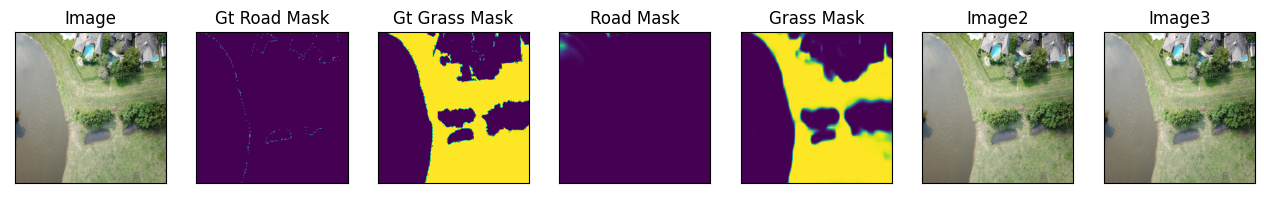

1/1 [==============================] - 0s 218ms/step


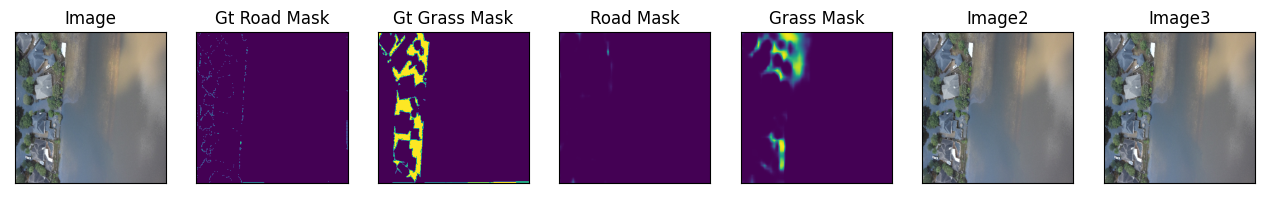

1/1 [==============================] - 0s 175ms/step


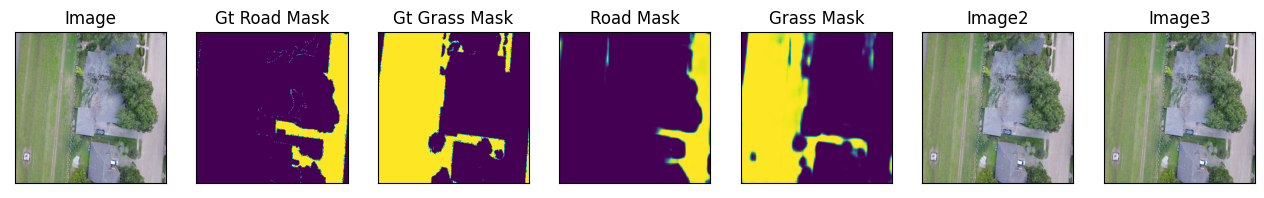

In [13]:
n = 3
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    im, gt_mask = test_dataset[i]
    image = np.expand_dims(im, axis=0)
    pr_mask = model.predict(image)

    viz.visualize(
        image=im,
        gt_road_mask=gt_mask[..., 0],
        gt_grass_mask=gt_mask[..., 1],
        road_mask=pr_mask.squeeze()[..., 0],
        grass_mask=pr_mask.squeeze()[..., 1],
        image2=im,
        image3=im,
    )

1/1 [==============================] - 0s 179ms/step
Road:  0 0
Grass:  184 224


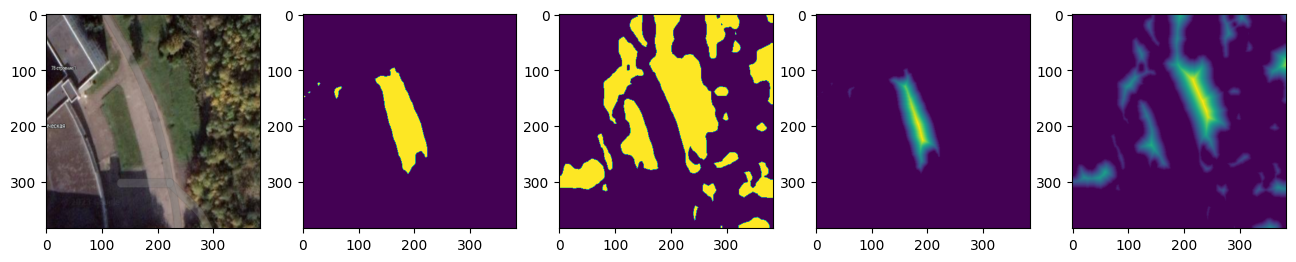

1/1 [==============================] - 0s 158ms/step
Road:  0 180
Grass:  162 204


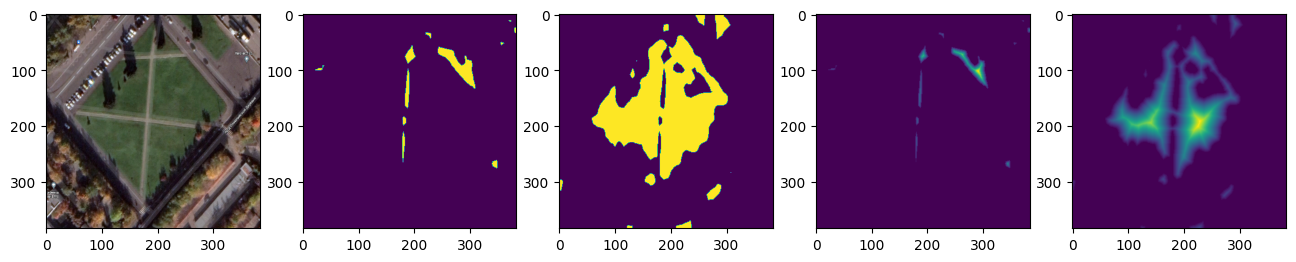

1/1 [==============================] - 0s 180ms/step
Road:  277 33
Grass:  153 186


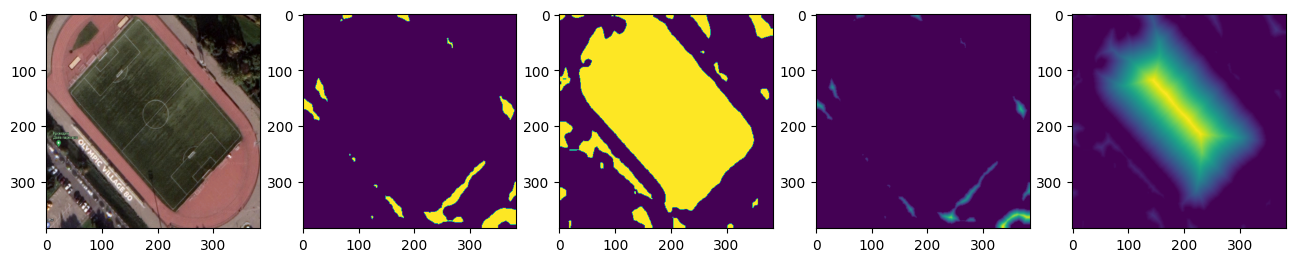

In [17]:
for n in range(3):
    image = cv2.imread(f'./include/test_image{n+1}.png', cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (384, 384))
    im = np.expand_dims(image, axis=0)
    pr_mask = model.predict(im)

    mask_road = pr_mask.squeeze()[..., 0]
    mask_grass = pr_mask.squeeze()[..., 1]

    for i in range(mask_road.shape[0]):
        for j in range(mask_road.shape[1]):
            mask_road[i][j] = 1 if mask_road[i][j] >= 0.5 else 0
    mask_road = mask_road.astype('uint8')

    for i in range(mask_grass.shape[0]):
        for j in range(mask_grass.shape[1]):
            mask_grass[i][j] = 1 if mask_grass[i][j] >= 0.5 else 0
    mask_grass = mask_grass.astype('uint8')

    mask_road = cv2.distanceTransform(mask_road, cv2.DIST_L2, 3)
    mask_grass = cv2.distanceTransform(mask_grass, cv2.DIST_L2, 3)

    print('Road: ', int(np.median(np.argmax(mask_road, axis=0))), int(np.median(np.argmax(mask_road, axis=1))))
    print('Grass: ', int(np.median(np.argmax(mask_grass, axis=0))), int(np.median(np.argmax(mask_grass, axis=1))))

    plt.figure(figsize=(16, 6))
    plt.subplot(151)
    plt.imshow(image)
    plt.subplot(152)
    plt.imshow(pr_mask.squeeze()[..., 0])
    plt.subplot(153)
    plt.imshow(pr_mask.squeeze()[..., 1])
    plt.subplot(154)
    plt.imshow(mask_road)
    plt.subplot(155)
    plt.imshow(mask_grass)
    plt.show()